# ML Project on Cricket Match Prediction 

# Libraries

In [35]:
import pandas as pd
import numpy as np 
import math
from sklearn import svm
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

# Importing Data

In [36]:
df = pd.read_csv('psl_formated.csv')
df.head()


,psl_year,match_number,team_1,team_2,inning,over,ball,runs,total_runs,wickets,is_four,is_six,is_wicket,wicket,wicket_text,result
0,2016,1,Islamabad United,Quetta Gladiators,1,1,1,0,0,0,False,False,False,NaN,NaN,Gladiators
1,2016,1,Islamabad United,Quetta Gladiators,1,1,2,0,0,0,False,False,False,NaN,NaN,Gladiators
2,2016,1,Islamabad United,Quetta Gladiators,1,1,3,0,0,0,False,False,False,NaN,NaN,Gladiators
3,2016,1,Islamabad United,Quetta Gladiators,1,1,4,0,0,0,False,False,False,NaN,NaN,Gladiators
4,2016,1,Islamabad United,Quetta Gladiators,1,1,5,0,0,0,False,False,False,NaN,NaN,Gladiators


# Data preprocessing

In [37]:
df['wicket'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.,  8.])

In [38]:
df['wicket_text'].unique()

array([nan, 'caught', 'bowled', 'lbw', 'run out', 'stumped', 'hit wicket',
       'obstruct field'], dtype=object)

In [39]:
df['wicket'].fillna(0,inplace = True)
df.head()

,psl_year,match_number,team_1,team_2,inning,over,ball,runs,total_runs,wickets,is_four,is_six,is_wicket,wicket,wicket_text,result
0,2016,1,Islamabad United,Quetta Gladiators,1,1,1,0,0,0,False,False,False,0.0,NaN,Gladiators
1,2016,1,Islamabad United,Quetta Gladiators,1,1,2,0,0,0,False,False,False,0.0,NaN,Gladiators
2,2016,1,Islamabad United,Quetta Gladiators,1,1,3,0,0,0,False,False,False,0.0,NaN,Gladiators
3,2016,1,Islamabad United,Quetta Gladiators,1,1,4,0,0,0,False,False,False,0.0,NaN,Gladiators
4,2016,1,Islamabad United,Quetta Gladiators,1,1,5,0,0,0,False,False,False,0.0,NaN,Gladiators


#### Hence, we replaced the nans in the 'wicket' column with 0.

# Boundaries Count

In [40]:
boundries_df = df.groupby(['psl_year']).agg(
    fours = ('is_four','sum'),
    sixes = ('is_six','sum'),
    matches = ('match_number','max')
    
)
boundries_df = boundries_df.reset_index()
boundries_df

,psl_year,fours,sixes,matches
0,2016,566,247,24
1,2017,552,258,24
2,2018,774,414,34
3,2019,878,374,34
4,2020,873,383,34


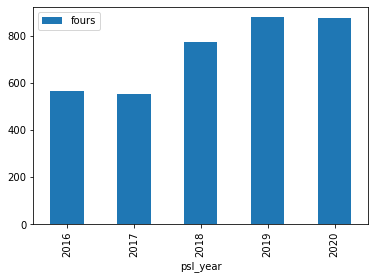

In [41]:
ax = boundries_df.plot('psl_year', 'fours', kind='bar')

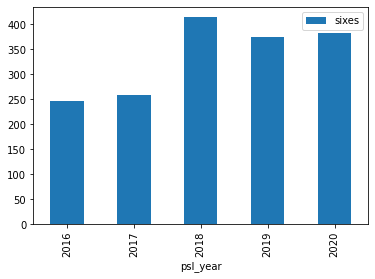

In [42]:
ax = boundries_df.plot('psl_year', 'sixes', kind='bar')

In [43]:
boundries_df['fours_per_match'] = boundries_df['fours']/boundries_df['matches']
boundries_df['six_per_match'] = boundries_df['sixes']/boundries_df['matches']

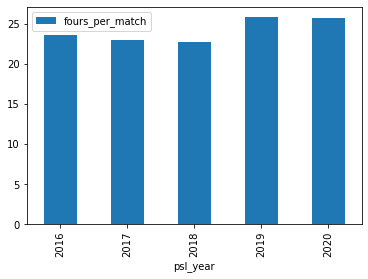

In [44]:
ax = boundries_df.plot('psl_year', 'fours_per_match', kind='bar')

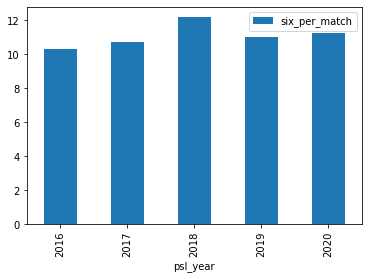

In [45]:
ax = boundries_df.plot('psl_year', 'six_per_match', kind='bar')

# Wickets

In [46]:
wickets = df['wicket_text'].value_counts()
wicket_dict = dict(wickets)
del_keys = []
others = 0
for key, value in wicket_dict.items():
    if value <100:
        others = others+value
        del_keys.append(key)
for del_key in del_keys:
    del(wicket_dict[del_key])
wicket_dict['others']= others
wicket_dict

{'caught': 1147, 'bowled': 328, 'run out': 165, 'lbw': 130, 'others': 46}

<BarContainer object of 5 artists>

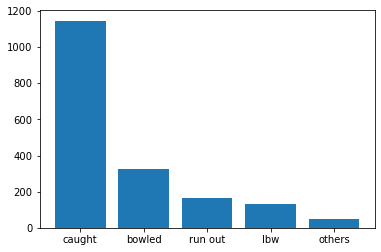

In [47]:
plt.bar(*zip(*wicket_dict.items()))

# Team Based Dataframes

In [48]:
teams_df = {'Quetta' : df.loc[((df['team_1'] == "Quetta Gladiators") & (df['inning'] == 1)) | ((df['team_2'] == "Quetta Gladiators") & (df['inning'] == 2))],
'Lahore' : df.loc[((df['team_1'] == "Lahore Qalandars") & (df['inning'] == 1)) | ((df['team_2'] == "Lahore Qalandars") & (df['inning'] == 2))],
'Islamabad' : df.loc[((df['team_1'] == "Islamabad United") & (df['inning'] == 1)) | ((df['team_2'] == "Islamabad United") & (df['inning'] == 2))],
'Peshawar' : df.loc[((df['team_1'] == "Peshawar Zalmi") & (df['inning'] == 1)) | ((df['team_2'] == "Peshawar Zalmi") & (df['inning'] == 2))],
'Multan' : df.loc[((df['team_1'] == "Multan Sultans") & (df['inning'] == 1)) | ((df['team_2'] == "Multan Sultans") & (df['inning'] == 2))],
'Karachi' : df.loc[((df['team_1'] == "Karachi Kings") & (df['inning'] == 1)) | ((df['team_2'] == "Karachi Kings") & (df['inning'] == 2))]
}

# Team Based Runs

In [49]:
team_runs = {}
for team_name, value in teams_df.items():
    team_runs[team_name] = value['runs'].sum()
team_matches = {}
for team_name , value in teams_df.items():
    team_matches[team_name] = value.groupby(['psl_year', 'match_number']).ngroups

<BarContainer object of 6 artists>

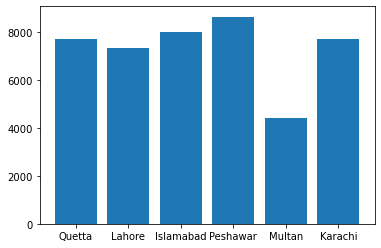

In [50]:
plt.bar(*zip(*team_runs.items()))

#### Among all the teams Peshawar scored the most runs, followed by Islamabad United.

# Team Based Percentage Runs in Boundaries

In [51]:
team_boundry_runs = {}
for team_name, value in teams_df.items():
    sixes = value['is_six'].sum()
    fours = value['is_four'].sum()
    team_boundry_runs[team_name]= (sixes*6)+(fours*4)

boundry_run_percentage = {}
for team, runs in team_runs.items():
    boundry_run_percentage[team] = (team_boundry_runs[team]/runs)*100

<BarContainer object of 6 artists>

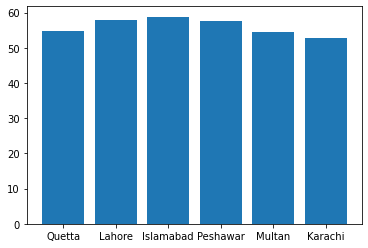

In [52]:
plt.bar(*zip(*boundry_run_percentage.items()))

#### This bar chart shows that Islamabad United dealt more in boundaries to score the runs.

# Dot Balls Played

In [53]:
dot_balls_played = {}
total_balls_played = {}
for team, value in teams_df.items():
    dot_balls_played[team]=value[value['runs']==0].shape[0]
    total_balls_played[team]= value.shape[0]

dot_ball_percentage ={}
for team , value in dot_balls_played.items():
    dot_ball_percentage[team] = (value/total_balls_played[team])*100


<BarContainer object of 6 artists>

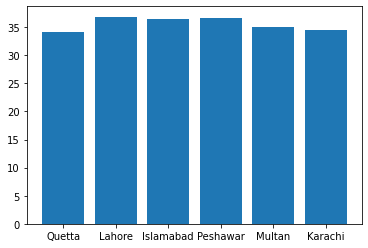

In [54]:
plt.bar(*zip(*dot_ball_percentage.items()))

#### Here, it shows that Lahore Qalanders played the most Dot balls.

# Six Hit Per Team

<BarContainer object of 6 artists>

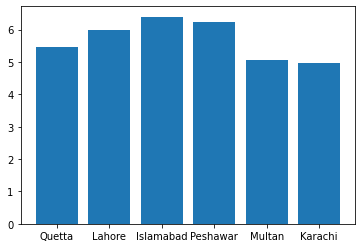

In [55]:
six_per_team = {}
for team, value in teams_df.items():
    six_per_team[team] = value['is_six'].sum()

six_per_match ={}
for team ,value in six_per_team.items():
    six_per_match[team] = value/team_matches[team]

plt.bar(*zip(*six_per_match.items()))

#### Talking about sixes hit by the teams, Islamabad United placed the most sixes per match.

<BarContainer object of 6 artists>

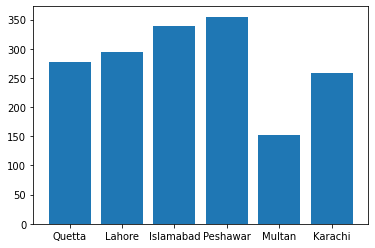

In [56]:
plt.bar(*zip(*six_per_team.items()))

#### Talking about sixes hit by the teams, Peshawar Zalmi placed the most sixes per team.

# Four Hit Per Team

<BarContainer object of 6 artists>

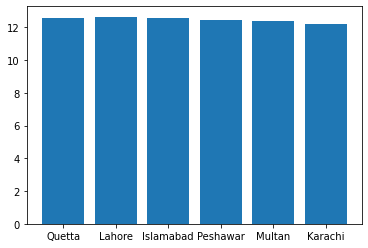

In [57]:
four_per_team = {}
for team, value in teams_df.items():
    four_per_team[team] = value['is_four'].sum()

four_per_match ={}
for team ,value in four_per_team.items():
    four_per_match[team] = value/team_matches[team]

plt.bar(*zip(*four_per_match.items()))

#### It seems a coincidence that all the teams scored almost similar number of fours per match.

# Runs Scored Per Team

<BarContainer object of 6 artists>

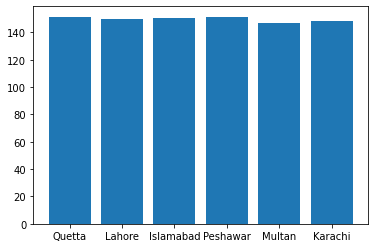

In [58]:
runs_per_team = {}
for team, value in teams_df.items():
    runs_per_team[team] = value['runs'].sum()

runs_per_match ={}
for team ,value in runs_per_team.items():
    runs_per_match[team] = value/team_matches[team]

plt.bar(*zip(*runs_per_match.items()))

#### Here, again it seems that all the teams scored almost similar number of runs per match.

# Wickets Per Team

<BarContainer object of 6 artists>

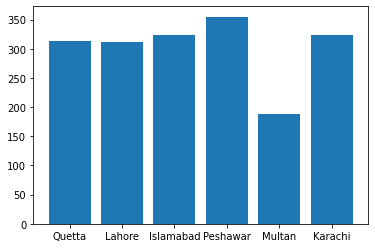

In [59]:
wickets_per_team = {}
for team, value in teams_df.items():
    wickets_per_team[team] = value['is_wicket'].sum()

wickets_per_match ={}
for team ,value in wickets_per_team.items():
    wickets_per_match[team] = value/team_matches[team]

plt.bar(*zip(*wickets_per_team.items()))

#### The above barchart shows that, Peshawar Zalmi had the most wickets being fallen per team.

<BarContainer object of 6 artists>

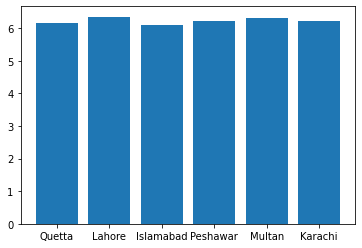

In [60]:
plt.bar(*zip(*wickets_per_match.items()))

In [61]:
# Method to calculate if the team batting second won or not
def is_winner(row):
    if type(row['result']) == str:
        if row['result'] in row['team_2']:
            return 1
        return 0
    else:
        return 0

In [62]:
# Method to calculate if a player was dismissed on this ball or not
def is_out(row):
    if type(row['player_dismissed']) == str:
        return 1
    else:
        return 0

# Data Manipulation to Extract Important Features

In [63]:
# Splitting on Innings
first_inning = df[df['inning']==1]
second_inning = df[df['inning']==2]

In [64]:
# Calculating Target
total_sum = first_inning.groupby(["psl_year","match_number"]).agg(
   target= ("runs","sum")
)

In [65]:
total_sum = total_sum.reset_index()

In [66]:
# Merging the DF
new_df = pd.merge(total_sum, second_inning,  how='left', left_on=['psl_year','match_number'], right_on = ['psl_year','match_number'])

In [67]:
# Calculating if Second Inning team won or not 
new_df['won'] = new_df.apply(is_winner, axis=1)

In [68]:
# Calculating balls left
new_df['balls_left'] = 120-(((new_df['over']-1)*6)+new_df['ball'])

In [69]:
# Creating the Final Dataset
final_df = new_df[['over','ball','total_runs','wickets','target','balls_left','won']]

In [70]:
final_df.head()

,over,ball,total_runs,wickets,target,balls_left,won
0,1.0,1.0,0.0,0.0,128,119.0,1
1,1.0,2.0,0.0,0.0,128,118.0,1
2,1.0,3.0,0.0,0.0,128,117.0,1
3,1.0,4.0,2.0,0.0,128,116.0,1
4,1.0,5.0,2.0,0.0,128,115.0,1


In [71]:
final_df['runs_left'] = final_df['target']- final_df['total_runs']

C:\Users\LENOVO\AppData\Local\Temp/ipykernel_15736/3345168847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['runs_left'] = final_df['target']- final_df['total_runs']


# Selecting particular columns for our model

In [72]:
new_cols =['wickets','balls_left','runs_left','won']

In [73]:
psl_df = final_df[new_cols]
psl_df.head()

,wickets,balls_left,runs_left,won
0,0.0,119.0,128.0,1
1,0.0,118.0,128.0,1
2,0.0,117.0,128.0,1
3,0.0,116.0,126.0,1
4,0.0,115.0,126.0,1


In [74]:
psl_df.isnull().sum()

wickets       2
balls_left    2
runs_left     2
won           0
dtype: int64

In [75]:
psl_df.shape

(16318, 4)

In [76]:
psl_df = psl_df.apply (pd.to_numeric, errors='coerce')
psl_df = psl_df.dropna()

In [77]:
psl_df.shape

(16316, 4)

In [78]:
# X and Y Split
y = psl_df.iloc[:,3]
X = psl_df.iloc[:,:3]

# Train Test split

In [79]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

# Pridiction with Decision Tree

In [80]:
model = tree.DecisionTreeClassifier()

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)


In [81]:
accuracy_score(y_test, y_pred_test)

0.7797181372549019

In [82]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1229
           1       0.83      0.82      0.82      2035

    accuracy                           0.78      3264
   macro avg       0.77      0.77      0.77      3264
weighted avg       0.78      0.78      0.78      3264



# predictions with XGBoost Classifier

In [83]:
XGBC = xgboost.XGBClassifier()
XGBC.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [84]:
y_pred = XGBC.predict(X_test)
predictions = [round(value) for value in y_pred]

In [85]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.31%


In [86]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1229
           1       0.82      0.90      0.86      2035

    accuracy                           0.81      3264
   macro avg       0.81      0.78      0.79      3264
weighted avg       0.81      0.81      0.81      3264



In [87]:
current= {
    "wickets":1,
    "balls_left" :105,
    "runs_left":137
}
current_df = pd.DataFrame(current,index=[0])
XGBC.predict_proba(current_df)

array([[0.22686851, 0.7731315 ]], dtype=float32)

# Making predictions with SVM 

In [88]:
SVC_model = svm.SVC()

SVC_model.fit(X_train, y_train)

predicted = SVC_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using SVC Classifier is:',format(a*100))

The accuracy using SVC Classifier is: 78.09436274509804


In [89]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.77      0.60      0.67      1229
           1       0.79      0.89      0.84      2035

    accuracy                           0.78      3264
   macro avg       0.78      0.74      0.75      3264
weighted avg       0.78      0.78      0.77      3264



# Pridiction With Logistic


In [90]:
model = LogisticRegression()

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

In [91]:
accuracy_score(y_test, y_pred_test)

0.7732843137254902

In [92]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1229
           1       0.80      0.86      0.82      2035

    accuracy                           0.77      3264
   macro avg       0.76      0.75      0.75      3264
weighted avg       0.77      0.77      0.77      3264

